Google colab link for the source code:[link text](https://colab.research.google.com/drive/1wVSBre1rwKadR9ydx13DeEFW4eYrFb9I#scrollTo=_biIKKXTiSGo)

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys

# Replace with the actual path to your library directory in Google Drive
library_path = '/content/drive/MyDrive/1'

if library_path not in sys.path:
    sys.path.append(library_path)

Mounted at /content/drive


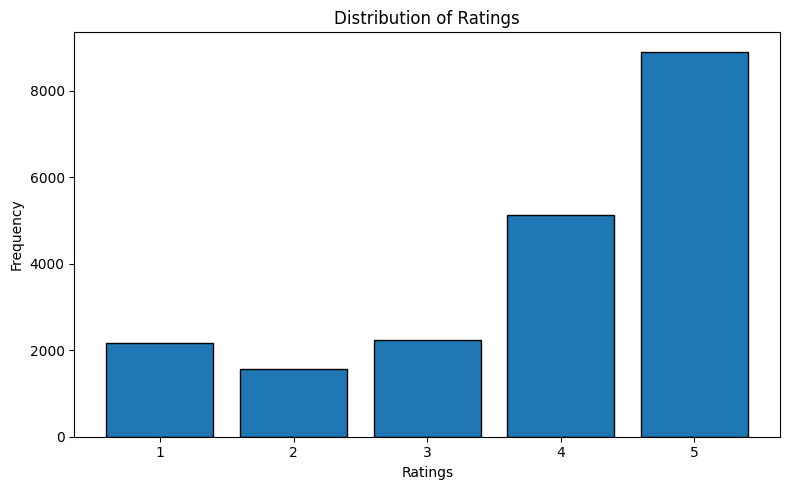

<ipython-input-2-b1efc6a448ff>:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('labels', group_keys=False).apply(


              business_id  labels  \
0  F7jNP74WiqPZILJXGPByQw       2   
1  qxDVtIq0EtvOtVKDwbYOiQ       3   
2  b7V_5q22_eTeHlYzq1bpFw       3   
3  RgAUDZXDJYwz7BI6u9aP5w       2   
4  EImGEwaos0pIqyye1u6OSA       1   

                                              review  
0  Food was ok and reasonably priced. The veal Ch...  
1  This was my first visit to this location, alth...  
2  Husband and I made a mistake and came here on ...  
3  I was really disappointed in my experience. Th...  
4  Not impressed. My husband and I decided to try...  
Processed DataFrame rows: 5000


In [ ]:
# Create folders
!mkdir -p data
!mkdir -p results
!mkdir -p embeddings

import pandas as pd
import matplotlib.pyplot as plt

# Load Yelp review JSON from mounted Drive or upload manually
json_file_path = '/content/drive/MyDrive/1/data/yelp_academic_dataset_review.json'  # Adjust path if using Drive

# Read data in chunks
df_list = []
chunk_size = 10000
desired_records = 20000
records_read = 0

chunks = pd.read_json(json_file_path, lines=True, chunksize=chunk_size)

for chunk in chunks:
    df_list.append(chunk)
    records_read += chunk.shape[0]
    if records_read >= desired_records:
        break

df = pd.concat(df_list, ignore_index=True)

# Select and rename columns
df = df[['business_id', 'stars', 'text']].rename(columns={'stars': 'labels', 'text': 'review'})
df = df.dropna(subset=['review'])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df['labels'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
         edgecolor='black', align='mid', rwidth=0.8)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.tight_layout()
plt.savefig('results/histogram.png')
plt.show()

# Balance the dataset
min_class_count = 1000
balanced_df = df.groupby('labels', group_keys=False).apply(
    lambda x: x.sample(n=min_class_count, random_state=42)
).reset_index(drop=True)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to pickle
balanced_df.to_pickle('/content/drive/MyDrive/1/data/yelp_processed.pkl')

# Preview
print(balanced_df.head())
print("Processed DataFrame rows:", balanced_df.shape[0])

In [ ]:
import pandas as pd
import spacy
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import logging
from encoders.BERT import BertEmbedder
from encoders.T5 import T5Embedder
from encoders.word2vec import Word2VecEmbedder

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def download_spacy_model():
    import spacy.cli
    spacy.cli.download("en_core_web_md")

def process_model_chunked(model_name, embedder_class, df, chunk_size=100):
    try:
        embedder = embedder_class()
        all_embeddings = []

        for i in range(0, len(df), chunk_size):
            chunk = df.iloc[i:i+chunk_size].copy()
            logger.info(f"{model_name}: Processing chunk {i}–{i+chunk_size}")

            chunk[f'{model_name.lower()}_embeddings'] = chunk['review'].apply(embedder.get_embeddings)
            chunk = chunk[chunk[f'{model_name.lower()}_embeddings'].notnull()]  # Drop failed rows

            all_embeddings.append(chunk)

        combined = pd.concat(all_embeddings, ignore_index=True)
        combined.to_pickle(f'embeddings/yelp_{model_name}_embeddings.pkl')
        logger.info(f"✅ Generated {model_name} embeddings")
    except Exception as e:
        logger.error(f"❌ Error processing {model_name}: {e}")

def main():
    download_spacy_model()
    df = pd.read_pickle('/content/drive/MyDrive/1/data/yelp_processed.pkl')

    embedders = [
        ('BERT', BertEmbedder),
        ('T5', T5Embedder),
        ('Word2Vec', Word2VecEmbedder),
    ]

    # Parallel using threads (safer for Colab)
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [
            executor.submit(process_model_chunked, name, embedder, df.copy())
            for name, embedder in embedders
        ]
        for future in futures:
            future.result()

if __name__ == "__main__":
    main()


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from decoders.svm import SVMClassifier
from decoders.logistic_regression import LogisticRegressionClassifier
from decoders.CNN import CNNClassifier
from decoders.Gradient_Boosting import GradientBoostingClassifierWrapper
from decoders.MLP import MLPClassifier
from decoders.Random_Forest import RandomForestClassifierWrapper
from sklearn.feature_extraction.text import TfidfTransformer
import pickle
import inspect

def train_and_save_classifier(classifier, X, y, file_suffix):
    # Check if the classifier requires input_dim parameter
    if 'input_dim' in inspect.signature(classifier.__init__).parameters:
        input_dim = X.shape[1]  # Assuming X is a 2D array where each row corresponds to a sample
        model = classifier(input_dim=input_dim)  # Provide the input_dim argument
    else:
        model = classifier()

    # Train the classifier
    model.train(X, y)

    # Save the results
    model.save_results(f'results/yelp_{file_suffix}.pkl')

def load_and_process_embeddings(file_path, column_name):
    # Read embeddings from a pickle file
    df = pd.read_pickle(file_path)

    # Convert the 'column_name' to NumPy arrays
    df[column_name] = df[column_name].apply(lambda x: np.array(x))
    X = np.array(df[column_name].tolist())
    y = df['labels'].values

    return X, y

def main():
    # List of embedding types and corresponding column names
    embeddings_list = [
        ('Word2Vec', 'word2vec_embeddings'),
        ('BERT', 'bert_embeddings'),
        ('T5', 't5_embeddings')
    ]

    # List of classifiers and their suffixes
    classifiers = [
        (LogisticRegressionClassifier, 'logistic_regression'),
        (SVMClassifier, 'svm'),
        (MLPClassifier, 'mlp'),
        (CNNClassifier, 'cnn'),
        (GradientBoostingClassifierWrapper, 'gradient_boosting'),
        (RandomForestClassifierWrapper, 'random_forest')
    ]

    # Loop through each embedding type and classifier
    for embedding_type, column_name in embeddings_list:
        file_path = f'/content/embeddings/yelp_{embedding_type}_embeddings.pkl'
        X, y = load_and_process_embeddings(file_path, column_name)

        for classifier, suffix in classifiers:
            # Train and save the classifier
            train_and_save_classifier(classifier, X, y, f'{embedding_type}_{suffix}')

if __name__ == "__main__":
    main()



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results saved to results/yelp_Word2Vec_logistic_regression.pkl
Results saved to results/yelp_Word2Vec_svm.pkl


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2691 - loss: 1.5768 - val_accuracy: 0.3770 - val_loss: 1.4490
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3919 - loss: 1.4116 - val_accuracy: 0.4070 - val_loss: 1.3675
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4055 - loss: 1.3561 - val_accuracy: 0.4130 - val_loss: 1.3525
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4170 - loss: 1.3386 - val_accuracy: 0.4130 - val_loss: 1.3514
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4407 - loss: 1.2961 - val_accuracy: 0.4240 - val_loss: 1.3231
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4491 - loss: 1.2934 - val_accuracy: 0.4310 - val_loss: 1.3030
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4594 - loss: 1.2815 - val_accuracy: 0.4140 - val_loss: 1.3170
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4456 - loss: 1.2763 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2114 - loss: 1.6123
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2065 - loss: 1.6049
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2265 - loss: 1.6026
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2318 - loss: 1.6004
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2452 - loss: 1.5937
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2617 - loss: 1.5854
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2571 - loss: 1.5769
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2702 - loss: 1.5666
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2789 - loss: 1.5619
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2729 - loss: 1.5588
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2709 - loss: 1.5620
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accurac

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results saved to results/yelp_BERT_logistic_regression.pkl
Results saved to results/yelp_BERT_svm.pkl
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3424 - loss: 1.4622 - val_accuracy: 0.5040 - val_loss: 1.1032
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5364 - loss: 1.0613 - val_accuracy: 0.5470 - val_loss: 1.0162
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5696 - loss: 0.9778 - val_accuracy: 0.5490 - val_loss: 1.0323
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5928 - loss: 0.9458 - val_accuracy: 0.5690 - val_loss: 1.0022
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6017 - loss: 0.9191 - val_accuracy: 0.5720 - val_loss: 1.0044
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6034 - loss: 0.9285 - val_accuracy: 0.5390 - val_loss: 1.0352
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6266 - loss: 0.8982 - val_accuracy: 0.5340 - val_loss: 1.0282
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6283 - loss: 0.8642 - val_accuracy: 0.5560 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2087 - loss: 1.6080
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2828 - loss: 1.5679
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3440 - loss: 1.4894
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3729 - loss: 1.4088
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3949 - loss: 1.3684
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3723 - loss: 1.3663
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3846 - loss: 1.3576
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4034 - loss: 1.3522
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3910 - loss: 1.3536
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3911 - loss: 1.3539
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3939 - loss: 1.3425
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results saved to results/yelp_T5_logistic_regression.pkl
Results saved to results/yelp_T5_svm.pkl
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2254 - loss: 1.6075 - val_accuracy: 0.4030 - val_loss: 1.4300
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4113 - loss: 1.3569 - val_accuracy: 0.4760 - val_loss: 1.1798
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5051 - loss: 1.1453 - val_accuracy: 0.4940 - val_loss: 1.0905
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5432 - loss: 1.0626 - val_accuracy: 0.5230 - val_loss: 1.0369
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5439 - loss: 1.0244 - val_accuracy: 0.5360 - val_loss: 1.0360
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5550 - loss: 1.0004 - val_accuracy: 0.5560 - val_loss: 0.9978
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5768 - loss: 0.9675 - val_accuracy: 0.5250 - val_loss: 1.0411
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5714 - loss: 0.9643 - val_accuracy: 0.5490 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2052 - loss: 1.6229
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2173 - loss: 1.6215
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2185 - loss: 1.6092
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2179 - loss: 1.6105
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2318 - loss: 1.6069
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2203 - loss: 1.6047
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2256 - loss: 1.6049
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2129 - loss: 1.6045
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2243 - loss: 1.6006
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2192 - loss: 1.6036
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2344 - loss: 1.5980
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results saved to results/yelp_T5_gradient_boosting.pkl
Results saved to results/yelp_T5_random_forest.pkl


In [ ]:
import pandas as pd
from pathlib import Path
import pickle

# Sample data for demonstration purposes (replace this with your actual data)
file_format = 'yelp_{}_{}.pkl'
encoders = ['Word2Vec', 'BERT', 'T5']
decoders = ['logistic_regression', 'svm', 'mlp', 'cnn', 'gradient_boosting', 'random_forest']

# Create DataFrames to store evaluation metrics
accuracy_data = pd.DataFrame(index=encoders, columns=decoders)
f1_data = pd.DataFrame(index=encoders, columns=decoders)
precision_data = pd.DataFrame(index=encoders, columns=decoders)
recall_data = pd.DataFrame(index=encoders, columns=decoders)
specificity_data = pd.DataFrame(index=encoders, columns=decoders)

for encoder in encoders:
    for decoder in decoders:
        file_path = Path('results') / file_format.format(encoder, decoder)

        try:
            with open(file_path, 'rb') as file:
                results_data = pickle.load(file)

            # Extract evaluation metrics from the results_data dictionary
            accuracy_value = results_data.get('accuracy', None)
            f1_value = results_data.get('weighted avg', {}).get('f1-score', None)
            precision_value = results_data.get('weighted avg', {}).get('precision', None)
            recall_value = results_data.get('weighted avg', {}).get('recall', None)



            # Update the DataFrames
            accuracy_data.loc[encoder, decoder] = accuracy_value
            f1_data.loc[encoder, decoder] = f1_value
            precision_data.loc[encoder, decoder] = precision_value
            recall_data.loc[encoder, decoder] = recall_value

        except FileNotFoundError:
            print(f"File not found: {file_path}")

# Display and save the tables
print("\nAccuracy Table:\n")
print(accuracy_data)
accuracy_csv_filename = 'results/accuracy_table.csv'
accuracy_data.to_csv(accuracy_csv_filename)
print(f"Accuracy table saved to {accuracy_csv_filename}")

print("\nF1 Table:\n")
print(f1_data)
f1_csv_filename = 'results/f1_table.csv'
f1_data.to_csv(f1_csv_filename)
print(f"F1 table saved to {f1_csv_filename}")

print("\nPrecision Table:\n")
print(precision_data)
precision_csv_filename = 'results/precision_table.csv'
precision_data.to_csv(precision_csv_filename)
print(f"Precision table saved to {precision_csv_filename}")

print("\nRecall Table:\n")
print(recall_data)
recall_csv_filename = 'results/recall_table.csv'
recall_data.to_csv(recall_csv_filename)
print(f"Recall table saved to {recall_csv_filename}")



Accuracy Table:

         logistic_regression    svm    mlp    cnn gradient_boosting  \
Word2Vec               0.439  0.397  0.457  0.325             0.421   
BERT                    0.54  0.573  0.514  0.444             0.476   
T5                     0.522  0.389  0.551   0.21             0.436   

         random_forest  
Word2Vec          0.38  
BERT             0.461  
T5               0.424  
Accuracy table saved to results/accuracy_table.csv

F1 Table:

         logistic_regression       svm       mlp       cnn gradient_boosting  \
Word2Vec            0.429747  0.392845  0.432939  0.298865          0.411955   
BERT                0.535872  0.568776  0.512571  0.425273          0.469128   
T5                  0.518472  0.336222  0.553231  0.124439          0.429713   

         random_forest  
Word2Vec      0.363897  
BERT          0.428514  
T5            0.376518  
F1 table saved to results/f1_table.csv

Precision Table:

         logistic_regression       svm       mlp       

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import csv

class SVMClassifier:
    def __init__(self, input_dim=None):
        self.model = SVC()
        self.results = {'classification_report': None}

    def train(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.model.fit(X_train, y_train)

        # Record overall metrics
        y_test_pred = self.model.predict(X_test)
        test_report = classification_report(y_test, y_test_pred, output_dict=True)
        self.results['classification_report'] = test_report

    def predict(self, input_embedding):
        # Make a prediction using the trained model
        return self.model.predict([input_embedding])

    def save_results(self, filename):
        # Save the overall metrics as a CSV file
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Class", "Precision", "Recall", "F1-Score", "Support"])
            for class_label, metrics in self.results['classification_report'].items():
                if class_label.isnumeric():
                    writer.writerow([class_label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])

        print(f"Results saved to {filename}")

def train_and_save_classifier(classifier, X, y, file_suffix):
    model = classifier()
    model.train(X, y)

    # Save the results
    filename = f'results/yelp_full_{file_suffix}.csv'
    model.save_results(filename)

    # Display the classification report
    print("Classification Report:")
    print(model.results['classification_report'])

    return model  # Return the trained model

def load_and_process_embeddings(file_path, column_name):
    df = pd.read_pickle(file_path)
    df[column_name] = df[column_name].apply(np.array)
    X = np.array(df[column_name].tolist())
    y = df['labels'].values

    return X, y

def main():
    # load the model and get the metrics

    embeddings_list = [('BERT', 'bert_embeddings')]

    classifiers = [
        (SVMClassifier, 'svm'),
    ]

    trained_models = []

    for embedding_type, column_name in embeddings_list:
        file_path = f'embeddings/yelp_{embedding_type}_embeddings.pkl'
        X, y = load_and_process_embeddings(file_path, column_name)

        for classifier, suffix in classifiers:
            trained_model = train_and_save_classifier(classifier, X, y, f'{embedding_type}_{suffix}')
            trained_models.append((trained_model, embedding_type))

    print("How the model will be used to make Predictions")

    # review recommendation for restaurant with id 'M0c99tzIJPIbrY_RAO7KSQ'

    file_path = 'embeddings/yelp_BERT_embeddings.pkl'

    # Read the pickle file into a DataFrame
    df = pd.read_pickle(file_path)

    # Specify the business ID you want to filter
    target_business_id = 'M0c99tzIJPIbrY_RAO7KSQ'

    # Create a new DataFrame with only rows that match the specified business ID
    filtered_df = df[df['business_id'] == target_business_id]

    # Display the new DataFrame
    print(filtered_df.head())

    # Calculate the average of the 'bart_embeddings' column
    average_embedding = np.mean(np.stack(filtered_df['bert_embeddings']), axis=0)

    print("Average Embedding:", average_embedding)

    # Make predictions using the trained models
    for trained_model, embedding_type in trained_models:
        prediction = trained_model.predict(average_embedding)
        print(f"Prediction using {embedding_type} model:", prediction)
        if prediction[0] == 1:
            print("Really don't go to this restaurant!")
        elif prediction[0] == 2:
            print("I would advise against it.")
        elif prediction[0] == 3:
            print("It's average.")
        elif prediction[0] == 4:
            print("I would advise for it.")
        elif prediction[0] == 5:
            print("Go to this restaurant!")

if __name__ == "__main__":
    main()


Results saved to results/yelp_full_BERT_svm.csv
Classification Report:
{'1': {'precision': 0.6473214285714286, 'recall': 0.8146067415730337, 'f1-score': 0.7213930348258707, 'support': 178.0}, '2': {'precision': 0.6010928961748634, 'recall': 0.514018691588785, 'f1-score': 0.5541561712846348, 'support': 214.0}, '3': {'precision': 0.43555555555555553, 'recall': 0.5104166666666666, 'f1-score': 0.47002398081534774, 'support': 192.0}, '4': {'precision': 0.48520710059171596, 'recall': 0.3942307692307692, 'f1-score': 0.4350132625994695, 'support': 208.0}, '5': {'precision': 0.6934673366834171, 'recall': 0.6634615384615384, 'f1-score': 0.6781326781326781, 'support': 208.0}, 'accuracy': 0.573, 'macro avg': {'precision': 0.5725288635153961, 'recall': 0.5793468815041585, 'f1-score': 0.5717438255316002, 'support': 1000.0}, 'weighted avg': {'precision': 0.5726480436870294, 'recall': 0.573, 'f1-score': 0.5687763408427503, 'support': 1000.0}}
How the model will be used to make Predictions
            